# NGRE and GRE data

### Authors:
Anna Igolkina

## Libraries & Paths

In [8]:
library(readxl)
library(ggplot2)
library(gridExtra)
library(grid)
options(repr.plot.width=10, repr.plot.height=7)

path_ngre_human = '../human/ngre/'
path_gre_human = '../human/gre/'
path_ngre_mouse = '../mouse/ngre/'
path_gre_mouse = '../mouse/gre/'

path_results = '../results/'



path_human = '../human/'
path_mouse = '../mouse/'

target_tags = c('H3K4me3', 'H3K27me3', 'H3K9me3')
target_stats = c('gre', 'ngre')

## Read NGRE and GRE data for Human

In [2]:
stat_all_h = c()  # Table to accumulate all statistics
for(tag in target_tags) 
{
    for(stat in target_stats)  # GRE or NGRE
    {
        path_stat = paste0(c(path_human, stat, '/'), collapse = '')
        files = list.files(path_stat)
        
        acc_stat = 0  # Accumulate GRE or NGRE, the mean across all cell lines
        for(file in files)
        {
            filename = paste0(path_stat, file)

            data = as.data.frame(read_excel(filename, sheet = tag))
            gene_names = data[,'Gene_name']
            acc_stat = acc_stat + data[,'total_signal']
        }
        acc_stat = acc_stat/length(files)
        length(gene_names)
        length(acc_stat)
        names(acc_stat) <- gene_names
        
        file_acc_stat = paste0(c(path_results, 'human_', stat, '_', tag, '.txt'), collapse = '')

        write.table(file = file_acc_stat, x = acc_stat, quote = FALSE, col.names = FALSE)
        
        # Accumulate all statistics
        stat_all_h = cbind(stat_all_h, acc_stat)
        colnames(stat_all_h)[ncol(stat_all_h)] <- paste0(c(stat, tag), collapse = '_')
    }  
}

Warning message in strptime(x, format, tz = tz):
“unknown timezone 'zone/tz/2018g.1.0/zoneinfo/Europe/Moscow'”

## Read NGRE and GRE data for Mouse

In [3]:
stat_all_m = c() 
for(tag in target_tags)
{
    for(stat in target_stats)  # GRE or NGRE
    {
        path_stat = paste0(c(path_mouse, stat, '/'), collapse = '')
        files = list.files(path_stat, pattern = paste0(c('*', tag, '.txt'), collapse=""))
        
        acc_stat = 0  # Accumulate GRE or NGRE, the mean across all cell lines
        for(file in files)
        {
            filename = paste0(path_stat, file)

            data = as.data.frame(read.table(filename,header  = TRUE))
            gene_names = data[,'gene']
            acc_stat = acc_stat + data[,'total_signal']
        }
        acc_stat = acc_stat/length(files)
        length(gene_names)
        length(acc_stat)
        names(acc_stat) <- gene_names

        file_acc_stat = paste0(c(path_results, 'mouse_', stat, '_', tag, '.txt'), collapse = '')

        write.table(file = file_acc_stat, x = acc_stat, quote = FALSE, col.names = FALSE)
        
        # Accumulate all statistics
        stat_all_m = cbind(stat_all_m, acc_stat)
        colnames(stat_all_m)[ncol(stat_all_m)] <- paste0(c(stat, tag), collapse = '_')
    }  
}


## Create Plots for "GRE vs NGRE" for Human & Mouse

In [6]:
plot_list = list()
for(stat_all in list(stat_all_h, stat_all_m))
{
    for(tag in target_tags) 
    {
        # Get profiles
        gre = stat_all[,paste0('gre_', tag)]
        ngre = stat_all[,paste0('ngre_', tag)]

        # Fit Linear Regressio with zero intercept
        slope = coef(lm(ngre ~ gre - 1))

        # Find outliers
        cutoff = 0.95
        point_dist = abs(-slope * gre + ngre) / slope
        idx_dist_up = ngre > slope * gre
        idx_dist_down = ngre < slope * gre

        point_dist_up = point_dist[idx_dist_up]
        point_dist_down = point_dist[idx_dist_down]

        threshold_up = quantile(point_dist_up, cutoff)
        threshold_down = quantile(point_dist_down, cutoff)


        outliers_up = idx_dist_up & (point_dist > threshold_up)
        outliers_down = idx_dist_down & (point_dist > threshold_down)
        normal_points = !outliers_up & !outliers_down

        # calculate correlation and p-value
        res = cor.test(gre, ngre)[c(3,4)]
        res_pval = as.character(round(res[[1]],2))
        res_cor = as.character(round(res[[2]],2))


        # Create plot
        p <- ggplot(as.data.frame(cbind(gre, ngre)), aes(gre, ngre)) + 
             geom_point(alpha=0.1, color = 2*outliers_up + 3*outliers_down + normal_points)+ 
             geom_abline(intercept = 0, slope = slope) +
             annotate("text", x=6, y=6, label= paste('corr: ', res_cor))+
             annotate("text", x=6, y=3, label= paste('p-value: ', res_pval)) + 
             ggtitle(paste0('Human ', tag))
        plot_list[[length(plot_list) + 1]] = p
    }
}

### Plotting

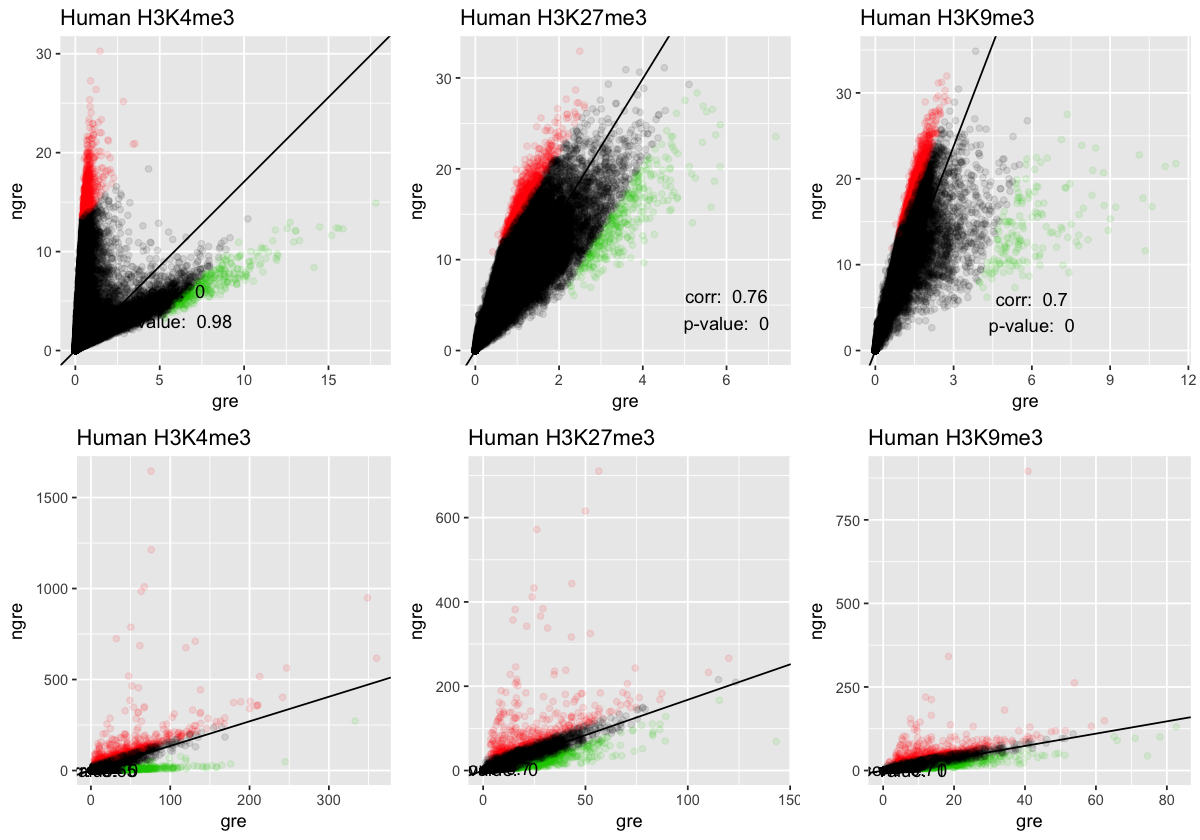

In [9]:
n <- length(plot_list)
nCol <- 3
do.call("grid.arrange", c(plot_list, ncol=nCol))